<a href="https://colab.research.google.com/github/MudassarAQazi/DL_Project_1_Leaf_Disease_Detection/blob/main/DL_Project_1_Leaf_Disease_Detection_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.923254259999993
GPU (s):
0.08065459499999861
GPU speedup over CPU: 73x


In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 10.7 MB/s eta 0:00:00


In [ ]:
!pip install -U tf2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


Importing required Libraries

In [ ]:
import numpy as np
import pickle
import h5py
import cv2
import os
from os import listdir
from tensorflow import keras as k
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
# from keras.layers import LeakyRelu
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras_preprocessing.image import img_to_array
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Example of loading an image with the Keras API
from keras_preprocessing.image import load_img

Parameters Initialization including the folder path.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pwd
os.getcwd()

'C:\\Users\\HOME'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
EPOCHS = 500
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = "../content/drive/MyDrive/PlantVillage"
# directory_root = "Downloads\DL\PlantVillage"
width=256
height=256
depth=3

In [ ]:
# !pwd
print(directory_root)

../content/drive/MyDrive/PlantVillage


Function that convert image into an array.

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetching images from the directories and saving it into an Array.

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Pepper_bell_Bacterial_spot ...
[INFO] Processing Pepper_bell_healthy ...
[INFO] Processing Potato_Early_blight ...
[INFO] Processing Potato_healthy ...
[INFO] Processing Potato_Late_blight ...
[INFO] Processing Tomato_Target_Spot ...
[INFO] Processing Tomato_Tomato_mosaic_virus ...
[INFO] Processing Tomato_Tomato_YellowLeaf_Curl_Virus ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Pepper_bell_Bacterial_spot' 'Pepper_bell_healthy' 'Potato_Early_blight'
 'Potato_Late_blight' 'Potato_healthy' 'Tomato_Bacterial_spot'
 'Tomato_Early_blight' 'Tomato_Late_blight' 'Tomato_Leaf_Mold'
 'Tomato_Septoria_leaf_spot' 'Tomato_Spider_mites_Two_spotted_spider_mite'
 'Tomato_Target_Spot' 'Tomato_Tomato_YellowLeaf_Curl_Virus'
 'Tomato_Tomato_mosaic_virus' 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
x_train.shape[0]

2361

In [ ]:
y_train.shape[0]

2361

In [ ]:
boom = np.argmax(y_train, axis = 1)

In [ ]:
boom = list(boom)

In [ ]:
val_keys = Counter(boom).keys() # equals to list(set(words))
val_boom = Counter(boom).values()

In [ ]:
val_keys = list(val_keys)

In [ ]:
val_boom = list(val_boom)

In [ ]:
val_boom

[168, 160, 170, 162, 161, 164, 153, 149, 162, 154, 146, 125, 163, 155, 169]

In [ ]:
Z = [x for _,x in sorted(zip(val_keys,val_boom))]

In [ ]:
Z

[154, 162, 169, 164, 125, 153, 163, 155, 146, 162, 160, 149, 168, 161, 170]

In [ ]:
classes = label_binarizer.classes_

In [ ]:
n_classes

15

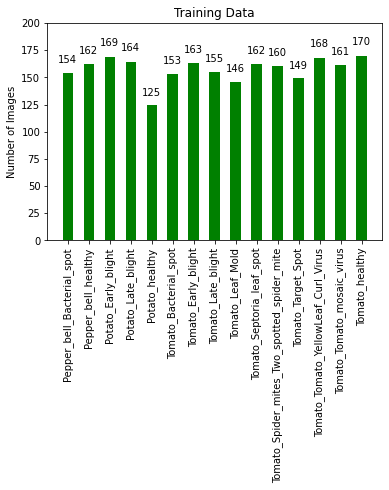

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(classes, Z, color ='green', width = 0.5)
ax.set_title('Training Data')
# ax.set_xticks(val_boom)
ax.set_xticklabels(classes, )
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees
ax.set_ylabel('Number of Images')

plt.ylim(top=200) 
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.show()

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

Setup for Tesnor board visualization

In [ ]:
 k.backend.clear_session()

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
# Conv1
model.add(Conv2D(96, (7, 7), padding="valid",strides=2,input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Pool1
model.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model.add(Dropout(0.25))
# Conv2
model.add(Conv2D(256, (3, 3), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Conv3
model.add(Conv2D(384, (7, 7), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Conv4
model.add(Conv2D(384, (9, 9), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Conv5
model.add(Conv2D(384, (3, 3), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Pool5
model.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model.add(Dropout(0.25))
# Conv6
model.add(Conv2D(256, (3, 3), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Pool6
model.add(MaxPooling2D(pool_size=(3, 3), padding = "same"))
model.add(Dropout(0.25))
# Flatten
model.add(Flatten())
# FC7
model.add(Dense(512))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# FC8
model.add(Dense(n_classes))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 96)      14208     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 125, 125, 96)      0         
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 42, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 256)       2

In [ ]:
from keras import callbacks
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
earlystopping = callbacks.EarlyStopping(monitor = 'loss', 
                                        mode = 'min', patience = 25,
                                        restore_best_weights = True)
# train the network
print("[INFO] Train the Network!!!")

[INFO] Train the Network!!!


In [ ]:
print("[INFO] training network...")
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1, 
    validation_freq=1,
    callbacks = [earlystopping]
    )

[INFO] training network...
Epoch 1/500
73/73 [==============================] - 92s 1s/step - loss: 0.2731 - accuracy: 0.2400 - val_loss: 0.4167 - val_accuracy: 0.1117
Epoch 2/500
73/73 [==============================] - 85s 1s/step - loss: 0.2044 - accuracy: 0.4113 - val_loss: 0.9471 - val_accuracy: 0.0575
Epoch 3/500
73/73 [==============================] - 85s 1s/step - loss: 0.1804 - accuracy: 0.4766 - val_loss: 0.6870 - val_accuracy: 0.0761
Epoch 4/500
73/73 [==============================] - 86s 1s/step - loss: 0.1596 - accuracy: 0.5303 - val_loss: 0.5825 - val_accuracy: 0.1455
Epoch 5/500
73/73 [==============================] - 85s 1s/step - loss: 0.1314 - accuracy: 0.6024 - val_loss: 0.4066 - val_accuracy: 0.2521
Epoch 6/500
73/73 [==============================] - 85s 1s/step - loss: 0.1202 - accuracy: 0.6376 - val_loss: 0.3896 - val_accuracy: 0.3080
Epoch 7/500
73/73 [==============================] - 84s 1s/step - loss: 0.1064 - accuracy: 0.6750 - val_loss: 1.0185 - val_acc

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
x_test.shape

(591, 256, 256, 3)

In [ ]:
y_test.shape

(591, 15)

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [ ]:
import pickle
print(pickle.__doc__)

Create portable serialized representations of Python objects.

See module copyreg for a mechanism for registering custom picklers.
See module pickletools source for extensive comments.

Classes:

    Pickler
    Unpickler

Functions:

    dump(object, file)
    dumps(object) -> string
    load(file) -> object
    loads(string) -> object

Misc variables:

    __version__
    format_version
    compatible_formats




In [ ]:
# save the model to disk
print("[INFO] Saving model...")
model.save("DL_Project_1_Leaf_Disease_Detection_Model_500_Epochs.h5")
print("Saved model to disk")


In [ ]:
from tensorflow.keras.models import load_model
# load model
model = load_model('../content/drive/MyDrive/DL_Project_1_Leaf_Disease_Detection_Model_250_Epochs.h5')

In [ ]:
os.path.exists("../content/drive/MyDrive/earlyblight.jpg")

True

In [ ]:
image_dir= "../content/drive/MyDrive/earlyblight.jpg"#"a.jpg"
im1 = load_img(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)


In [ ]:
result=model.predict(x_test)
print(result)

19/19 [==============================] - 8s 245ms/step
[[4.3600819e-13 9.9992895e-01 7.6689286e-09 ... 1.7219134e-10
  1.8020658e-07 1.5966592e-07]
 [2.2212479e-14 9.3537123e-14 4.6523344e-10 ... 4.5127135e-11
  1.1219270e-10 4.1227224e-10]
 [6.0603422e-10 2.9954444e-06 5.5504130e-09 ... 1.8251584e-09
  2.0056785e-07 7.2433591e-01]
 ...
 [1.5331761e-15 9.8638207e-19 1.6261784e-15 ... 1.0000000e+00
  1.0779128e-13 2.1470582e-16]
 [2.0723630e-06 4.2869981e-08 7.4231081e-12 ... 1.5194669e-07
  1.9950980e-10 1.1569148e-12]
 [5.5481192e-15 1.9017889e-16 7.2363926e-10 ... 5.6560735e-13
  1.5675964e-14 1.9609005e-13]]


In [ ]:
x_test.shape

(591, 256, 256, 3)

In [ ]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:1.0
Potato_Early_blight


In [ ]:
result.shape

(591, 15)

In [ ]:
result

array([[4.3600819e-13, 9.9992895e-01, 7.6689286e-09, ..., 1.7219134e-10,
        1.8020658e-07, 1.5966592e-07],
       [2.2212479e-14, 9.3537123e-14, 4.6523344e-10, ..., 4.5127135e-11,
        1.1219270e-10, 4.1227224e-10],
       [6.0603422e-10, 2.9954444e-06, 5.5504130e-09, ..., 1.8251584e-09,
        2.0056785e-07, 7.2433591e-01],
       ...,
       [1.5331761e-15, 9.8638207e-19, 1.6261784e-15, ..., 1.0000000e+00,
        1.0779128e-13, 2.1470582e-16],
       [2.0723630e-06, 4.2869981e-08, 7.4231081e-12, ..., 1.5194669e-07,
        1.9950980e-10, 1.1569148e-12],
       [5.5481192e-15, 1.9017889e-16, 7.2363926e-10, ..., 5.6560735e-13,
        1.5675964e-14, 1.9609005e-13]], dtype=float32)

In [ ]:
y_test.shape

(591, 15)

In [ ]:
import tensorflow as tf

In [ ]:
labels = tf.argmax(y_test,1)

In [ ]:
labels.shape

TensorShape([591])

In [ ]:
predictions = tf.argmax(result,1)

In [ ]:
predictions.shape

TensorShape([591])

In [ ]:
cm = tf.math.confusion_matrix(labels = tf.argmax(y_test,1), predictions = tf.argmax(result,1))

In [ ]:
cm = cm.numpy()

In [ ]:
cm

array([[44,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 37,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  2, 28,  0,  0,  0,  3,  0,  0,  1,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 44,  0,  0,  1,  0,  0,  0,  2,  0,  0],
       [ 1,  1,  0,  0,  0,  0, 31,  3,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  2,  4, 33,  0,  0,  1,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 52,  0,  0,  0,  1,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  1,  1,  9, 23,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0, 36,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  3,  0,  4,  0, 16, 17,  0,  1,  8],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 32,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 39,  0],
       [ 0,  0,  0,  0,  0,  0,  0

In [ ]:
classes = label_binarizer.classes_

In [ ]:
classes

array(['Pepper_bell_Bacterial_spot', 'Pepper_bell_healthy',
       'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy',
       'Tomato_Bacterial_spot', 'Tomato_Early_blight',
       'Tomato_Late_blight', 'Tomato_Leaf_Mold',
       'Tomato_Septoria_leaf_spot',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato_Target_Spot', 'Tomato_Tomato_YellowLeaf_Curl_Virus',
       'Tomato_Tomato_mosaic_virus', 'Tomato_healthy'], dtype='<U43')

In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

In [ ]:
cm

<tf.Tensor: shape=(15, 15), dtype=int32, numpy=
array([[44,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 37,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  2, 28,  0,  0,  0,  3,  0,  0,  1,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 44,  0,  0,  1,  0,  0,  0,  2,  0,  0],
       [ 1,  1,  0,  0,  0,  0, 31,  3,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  2,  4, 33,  0,  0,  1,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 52,  0,  0,  0,  1,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  1,  1,  9, 23,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0, 36,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  3,  0,  4,  0, 16, 17,  0,  1,  8],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 32,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [ ]:
df_cm = pd.DataFrame(cm, classes, classes)

In [ ]:
df_cm

,Pepper_bell_Bacterial_spot,Pepper_bell_healthy,Potato_Early_blight,Potato_Late_blight,Potato_healthy,Tomato_Bacterial_spot,Tomato_Early_blight,Tomato_Late_blight,Tomato_Leaf_Mold,Tomato_Septoria_leaf_spot,Tomato_Spider_mites_Two_spotted_spider_mite,Tomato_Target_Spot,Tomato_Tomato_YellowLeaf_Curl_Virus,Tomato_Tomato_mosaic_virus,Tomato_healthy
Pepper_bell_Bacterial_spot,44,0,0,0,0,0,1,0,0,1,0,0,0,0,0
Pepper_bell_healthy,0,37,0,0,0,0,0,1,0,0,0,0,0,0,0
Potato_Early_blight,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0
Potato_Late_blight,1,0,2,28,0,0,0,3,0,0,1,0,0,0,1
Potato_healthy,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0
Tomato_Bacterial_spot,0,0,0,0,0,44,0,0,1,0,0,0,2,0,0
Tomato_Early_blight,1,1,0,0,0,0,31,3,0,0,1,0,0,0,0
Tomato_Late_blight,0,0,1,0,0,2,4,33,0,0,1,0,0,0,4
Tomato_Leaf_Mold,0,0,0,0,0,0,0,1,52,0,0,0,1,0,0
Tomato_Septoria_leaf_spot,1,1,0,0,0,0,1,1,9,23,1,0,1,0,0


In [ ]:
plt.figure(figsize = (10,7))

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sn

Text(32.093749999999986, 0.5, 'True Classes')

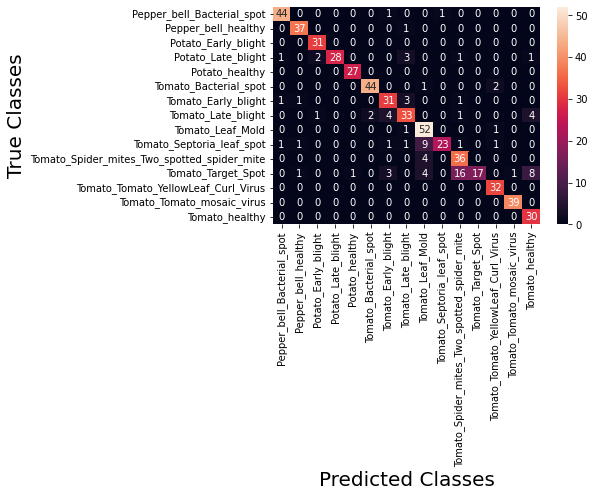

In [ ]:
confusion_matrics = sn.heatmap(df_cm, annot  =True)
confusion_matrics.set_xlabel('Predicted Classes', fontsize=20)
confusion_matrics.set_ylabel('True Classes', fontsize=20)